# Laboratorium 3

### Konfiguracja

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [9]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

In [10]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

# plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

In [11]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
# plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

In [12]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
# plot1.draw()

In [13]:
plot2 = Plot([plot1.get_added_elements()])
# plot2.draw()

AttributeError: 'Plot' object has no attribute 'callback'

### Rozwiązanie

In [14]:
%matplotlib notebook

from Sweeping import *

def class_line_to_draw(lines):
    ls = []
    for line in lines:
        l = [(line.p.x, line.p.y), (line.q.x, line.q.y)]
        ls.append(l)
    return ls

def class_point_to_draw(points):
    ps = []
    for point in points:
        p = (point.x, point.y)
        ps.append(p)
    return ps

[[(10.365002914864341, 12.041582037540122), (54.768282621704714, 21.639817543382357), 12.041582037540122], [(15.874584311622497, 3.035147957440343), (59.3448685277256, 77.78621697194637), 3.035147957440343], [(30.99561408998156, 40.89606450925979), (70.07030755049945, 2.93204191280525), 2.93204191280525], [(26.716044648351357, 28.004931510446518), (74.74525150652337, 10.650675739111692), 10.650675739111692], [(9.911837336688034, 0.23954679485501673), (88.48429408392545, 62.18094183526792), 0.23954679485501673], [(4.050804956525155, 6.989783404617455), (87.40565128787522, 48.76037538666152), 6.989783404617455], [(36.20237971450359, 42.59093512282317), (38.14066847485964, 9.284617894638869), 9.284617894638869], [(15.899361026189219, 18.433078116672064), (93.43779120586994, 19.88589061067104), 18.433078116672064], [(13.025614412251274, 56.76568660260598), (72.03066677902879, 3.6537277166188264), 56.76568660260598], [(34.560664380765104, 3.802147832509517), (55.59217722100037, 86.615865253

AttributeError: 'NoneType' object has no attribute 'bottom_segment'

In [15]:
# %matplotlib notebook

# from Sweeping import *

# # p = [(1, 5, 'A'), (90, 30, 'B'), (10, 25, 'C'), (110, 20, 'D'), (15, 15, 'E'),
# #      (31, 23, 'F'), (30, 21, 'G'), (35, 18, 'H'), (70, 30, 'I'), (85, 8, 'J'),
# #      (80, 35, 'K'), (90, 8, 'L'), (30.5, 23, 'M'), (31, 22, 'N')]
# # points = Point.add_multiple_points(p)

# # ls = LineSegment.add_multiple_line_segments(points)
# ls = generate_lines(0, 100, 10)

# lines = class_line_to_draw(ls)

# scenes=[Scene(lines=[LinesCollection(lines)])]
# plot = Plot(scenes)

# ps = class_point_to_draw(sweeping(ls))
# print(ps)

# plot.add_scene(Scene([PointsCollection(ps)], [LinesCollection(lines)]))
# plot.draw()

In [16]:
# %matplotlib notebook

# from Sweeping import *

# lines = [[(10.365002914864341, 12.041582037540122), (54.768282621704714, 21.639817543382357), 12.041582037540122], [(15.874584311622497, 3.035147957440343), (59.3448685277256, 77.78621697194637), 3.035147957440343], [(30.99561408998156, 40.89606450925979), (70.07030755049945, 2.93204191280525), 2.93204191280525], [(26.716044648351357, 28.004931510446518), (74.74525150652337, 10.650675739111692), 10.650675739111692], [(9.911837336688034, 0.23954679485501673), (88.48429408392545, 62.18094183526792), 0.23954679485501673], [(4.050804956525155, 6.989783404617455), (87.40565128787522, 48.76037538666152), 6.989783404617455], [(36.20237971450359, 42.59093512282317), (38.14066847485964, 9.284617894638869), 9.284617894638869], [(15.899361026189219, 18.433078116672064), (93.43779120586994, 19.88589061067104), 18.433078116672064], [(13.025614412251274, 56.76568660260598), (72.03066677902879, 3.6537277166188264), 56.76568660260598], [(34.560664380765104, 3.802147832509517), (55.59217722100037, 86.61586525310305), 3.802147832509517]]
# ls = []
# tmp = []
# for line in lines:
#     p1 = Point(line[0][0], line[0][1])
#     p2 = Point(line[1][0], line[1][0])
#     l = LineSegment(p1, p2)
#     ls.append(l)
#     tmp.append([(line[0][0], line[0][1]), (line[1][0], line[1][1])])
# # print(sweeping(ls))

# scenes=[Scene(lines=[LinesCollection(tmp)])]
# plot = Plot(scenes)
# plot.draw()

In [17]:
# %matplotlib notebook
# from sortedcontainers import SortedSet, SortedDict

# def sweepingAll(linesList):
#     if len(linesList) <2:
#         return ([],[])
#     scenes=[]
#     activeLines=SortedSet([],key=lambda x: x[0][1])
#     minY=linesList[0][0][1]
#     maxY=linesList[0][0][1]
#     events=[]
#     yLineDict=SortedDict()
#     for [p1,p2] in linesList:
#         events.append(((p1,p2),"start"))
#         events.append(((p2,p1),"end"))
#         minY=min(minY,p1[1],p2[1])
#         maxY=max(maxY,p1[1],p2[1])
#         yLineDict[(p1,p2)]=p1[1]
    
#     Q=SortedSet(events, key=lambda x:(x[0][0],x[0][1]))
#     T=SortedSet([],key=lambda x:x[1])
#     intersectionPoints=SortedSet([],key=lambda x: x[0])
#     sweepX=Q[0][0][0][0]
#     sweep=[[(sweepX,minY),(sweepX,maxY)]]
    
#     currentScene=Scene([PointsCollection([x for x in intersectionPoints],color='green')],
#                        [LinesCollection(linesList),LinesCollection(sweep,color='black')])
#     scenes.append(currentScene)
    
#     j=1
#     while Q:
#         event=Q.pop(0)
#         sweepX=event[0][0][0]
#         sweep=[[(sweepX,minY),(sweepX,maxY)]]
#         print("iteracja:",j,event)
#         for x in T:
#             print(x)
        
#         if event[1]=="start":
            
#             startLine=event[0]
#             activeLines.add(startLine)
#             T.add((startLine, startLine[0][1]))
#             i=T.index((startLine, startLine[0][1]))
#             n=len(T)
            
#             if i-1>=0:
#                 neighbour=T[i-1][0]
#                 (intersects, interPoint)= intersect(startLine,neighbour,defEps)
                
#                 if intersects and isOnLine(startLine,neighbour,interPoint) and interPoint[0] > sweepX:
#                     Q.add(((interPoint,startLine,neighbour),"intersection"))
#                     intersectionPoints.add(interPoint)
                    
#             if i+1 < n:
#                 neighbour=T[i+1][0]
#                 (intersects, interPoint)= intersect(startLine,neighbour,defEps)

#                 if intersects and isOnLine(startLine,neighbour,interPoint)and interPoint[0] > sweepX:
#                     Q.add(((interPoint,startLine,neighbour),"intersection"))
#                     intersectionPoints.add(interPoint)
                    
#         elif event[1]=="end":
#             startLine=event[0]
#             startLine=(startLine[1],startLine[0])
#             activeLines.remove(startLine)
#             i=T.index((startLine, yLineDict[startLine]))
#             T.remove((startLine, yLineDict[startLine]))
#             n=len(T)
            
#             if i-1>=0 and i <n:
#                 neighbour1=T[i-1][0]
#                 neighbour2=T[i][0]
#                 (intersects, interPoint)= intersect(neighbour1,neighbour2,defEps)
                
#                 if intersects and isOnLine(neighbour1,neighbour2,interPoint) and interPoint not in intersectionPoints and interPoint[0] > sweepX:
#                     Q.add(((interPoint,neighbour1,neighbour2),"intersection"))
#                     intersectionPoints.add(interPoint)
                    
#         else:
#             firstLine=event[0][1]
#             secondLine=event[0][2]
#             i2=T.index((firstLine,yLineDict[firstLine]))
#             i1=T.index((secondLine,yLineDict[secondLine]))
#             T.remove((firstLine,yLineDict[firstLine]))
#             T.remove((secondLine,yLineDict[secondLine]))

#             yLineDict[firstLine],yLineDict[secondLine] = yLineDict[secondLine],yLineDict[firstLine]

#             T.add((firstLine,yLineDict[firstLine]))
#             T.add((secondLine,yLineDict[secondLine]))
#             n=len(T)
            
            
#             if i1-1>=0 and i1-1 is not i2:
#                 neighbour=T[i1-1][0]
#                 (intersects, interPoint)= intersect(neighbour,firstLine,defEps)

#                 if intersects and isOnLine(neighbour,firstLine,interPoint) and interPoint not in intersectionPoints  and interPoint[0] > sweepX:
#                     Q.add(((interPoint,neighbour,firstLine),"intersection"))
#                     intersectionPoints.add(interPoint)
                
#             if i1+1<n and i1+1 is not i2:
#                 neighbour=T[i1+1][0]
#                 (intersects, interPoint)= intersect(firstLine,neighbour,defEps)

#                 if intersects and isOnLine(firstLine,neighbour,interPoint) and interPoint not in intersectionPoints  and interPoint[0] > sweepX:
#                     Q.add(((interPoint,firstLine,neighbour),"intersection"))
#                     intersectionPoints.add(interPoint)
                
#             if i2-1>=0 and i2-1 is not i1:
#                 neighbour=T[i2-1][0]
#                 (intersects, interPoint)= intersect(neighbour,secondLine,defEps)

#                 if intersects and isOnLine(neighbour,secondLine,interPoint) and interPoint not in intersectionPoints  and interPoint[0] > sweepX:
#                     Q.add(((interPoint,neighbour,secondLine),"intersection"))
#                     intersectionPoints.add(interPoint)
                
#             if i2+1<n and i2+1 is not i1:
#                 neighbour=T[i2+1][0]
#                 (intersects, interPoint)= intersect(secondLine,neighbour,defEps)

#                 if intersects and isOnLine(secondLine,neighbour,interPoint) and interPoint not in intersectionPoints  and interPoint[0] > sweepX:
#                     Q.add(((interPoint,secondLine,neighbour),"intersection"))
#                     intersectionPoints.add(interPoint)
                    
#         currentScene=Scene([PointsCollection([x for x in intersectionPoints],color='green')],
#                        [LinesCollection(linesList),LinesCollection(sweep,color='black'),LinesCollection([[x[0],x[1]] for x in activeLines],color='red')])
#         scenes.append(currentScene)
#         j=j+1
#         for x in intersectionPoints:
#             print(x)
#         print()
        
#     currentScene=Scene([PointsCollection([x for x in intersectionPoints],color='green')],
#                        [LinesCollection(linesList),LinesCollection(sweep,color='black')])
#     scenes.append(currentScene)
                    
#     return (intersectionPoints, scenes)

# %matplotlib notebook

# from Sweeping import *

# lines = [[(10.365002914864341, 12.041582037540122), (54.768282621704714, 21.639817543382357), 12.041582037540122], [(15.874584311622497, 3.035147957440343), (59.3448685277256, 77.78621697194637), 3.035147957440343], [(30.99561408998156, 40.89606450925979), (70.07030755049945, 2.93204191280525), 2.93204191280525], [(26.716044648351357, 28.004931510446518), (74.74525150652337, 10.650675739111692), 10.650675739111692], [(9.911837336688034, 0.23954679485501673), (88.48429408392545, 62.18094183526792), 0.23954679485501673], [(4.050804956525155, 6.989783404617455), (87.40565128787522, 48.76037538666152), 6.989783404617455], [(36.20237971450359, 42.59093512282317), (38.14066847485964, 9.284617894638869), 9.284617894638869], [(15.899361026189219, 18.433078116672064), (93.43779120586994, 19.88589061067104), 18.433078116672064], [(13.025614412251274, 56.76568660260598), (72.03066677902879, 3.6537277166188264), 56.76568660260598], [(34.560664380765104, 3.802147832509517), (55.59217722100037, 86.61586525310305), 3.802147832509517]]
# ls = []
# tmp = []
# for line in lines:
#     p1 = Point(line[0][0], line[0][1])
#     p2 = Point(line[1][0], line[1][0])
#     l = LineSegment(p1, p2)
#     ls.append(l)
#     tmp.append([(line[0][0], line[0][1]), (line[1][0], line[1][1])])
    
# xd = sweepingAll(tmp)

# plot=Plot(xd[1])
# plot.draw()

<IPython.core.display.Javascript object>


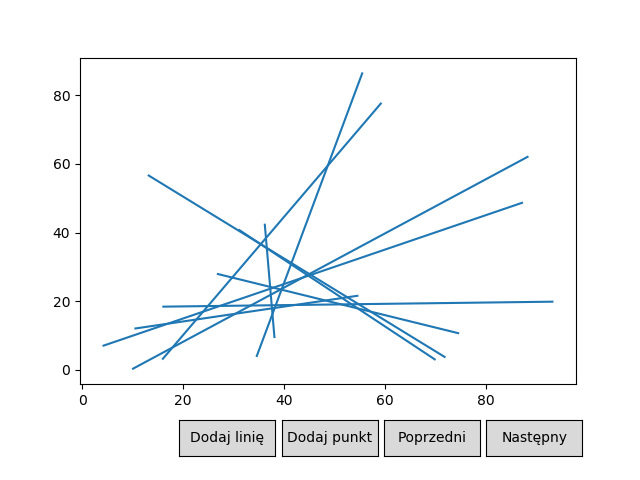

In [20]:
%matplotlib notebook

lines = [[(10.365002914864341, 12.041582037540122), (54.768282621704714, 21.639817543382357), 12.041582037540122], [(15.874584311622497, 3.035147957440343), (59.3448685277256, 77.78621697194637), 3.035147957440343], [(30.99561408998156, 40.89606450925979), (70.07030755049945, 2.93204191280525), 2.93204191280525], [(26.716044648351357, 28.004931510446518), (74.74525150652337, 10.650675739111692), 10.650675739111692], [(9.911837336688034, 0.23954679485501673), (88.48429408392545, 62.18094183526792), 0.23954679485501673], [(4.050804956525155, 6.989783404617455), (87.40565128787522, 48.76037538666152), 6.989783404617455], [(36.20237971450359, 42.59093512282317), (38.14066847485964, 9.284617894638869), 9.284617894638869], [(15.899361026189219, 18.433078116672064), (93.43779120586994, 19.88589061067104), 18.433078116672064], [(13.025614412251274, 56.76568660260598), (72.03066677902879, 3.6537277166188264), 56.76568660260598], [(34.560664380765104, 3.802147832509517), (55.59217722100037, 86.61586525310305), 3.802147832509517]]
ls = []
tmp = []
for line in lines:
#     p1 = Point(line[0][0], line[0][1])
#     p2 = Point(line[1][0], line[1][0])
#     l = LineSegment(p1, p2)
#     ls.append(l)
    tmp.append([(line[0][0], line[0][1]), (line[1][0], line[1][1])])

scenes=[Scene(lines=[LinesCollection(tmp)])]
plot = Plot(scenes)
plot.draw()